In [26]:
# Data Processing Imports
import pandas as pd
import os
from skimage.transform import resize, rotate, resize 
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt
import random
import copy

# Logger Imports
import time
import logging
import sys
from logging.handlers import TimedRotatingFileHandler

# Model Specific Imports
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.model_selection import train_test_split

from skimage import data, io
from matplotlib import pyplot as plt

from sklearn.linear_model import LogisticRegression

from sklearn import svm
from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import RandomForestClassifier

# Visulaization and metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import fbeta_score
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

In [27]:
# Sets up all standardized logger stuff
FORMATTER = logging.Formatter("%(asctime)s —  %(levelname)s — %(message)s")
LOG_FILE = "General_Script.log"

def get_console_handler():
    console_handler = logging.StreamHandler(sys.stdout)
    console_handler.setFormatter(FORMATTER)
    return console_handler

def get_file_handler():
    file_handler = TimedRotatingFileHandler(LOG_FILE, when='midnight')
    file_handler.setFormatter(FORMATTER)
    return file_handler

def get_logger(logger_name):
    logger = logging.getLogger(logger_name)
    
    if (logger.hasHandlers()): # important as removes duplicate loggers (and thus duplicate log entries)
        logger.handlers.clear()
    logger.setLevel(logging.DEBUG) # better to have too much log than not enough
    logger.addHandler(get_console_handler())
    logger.addHandler(get_file_handler())
    # with this pattern, it's rarely necessary to propagate the error up to parent
    logger.propagate = False
    return logger

logger = get_logger("General_Script")

In [28]:
# Loads all data from files. NOTE, the folder in which the img's are stored in dictates there health class. See comments for folder class

Categories_Durum=['CFP-CK1','CFP-CK2'] # [Infected, Healthy]
Categories_Bread=['CFP-CK3','CFP-CK4'] # [Infected, Healthy]
Categories_Test_B179 = ['CFP-B179-A','CFP-B179-B'] # [Infected, Healthy]
Categories_Test_B223 = ['CFP-B223-A','CFP-B223-B'] # [Infected, Healthy]

Infected_Categories = ['CFP-CK1', 'CFP-CK3', 'CFP-B179-A', 'CFP-B223-A']

All_Categories = [Categories_Durum, Categories_Bread, Categories_Test_B179, Categories_Test_B223]

datadir='/birl2/users/sch923/Thesis/Data/Wheat/TestSamples' 
#path which contains all the categories of images

In [34]:
# Pre-processing step

img_arr, label_arr = [],[]
total_imgs, total_infected, total_healthy = 0, 0, 0


# creating species specific data sets
for Categories in All_Categories:
    img_arr.append(list())
    label_arr.append(list())
    
    for i in Categories:
        logger.info(f'loading category: {i}')    
        path=os.path.join(datadir,i) 
        image_count = 0
        
        for img_path in os.listdir(path):  
            img=imread(os.path.join(path,img_path))
            img_resized=resize(img,(150,150,3))  
            img_arr[len(img_arr)-1].append(img_resized) # Saves flat images
            label_arr[len(img_arr)-1].append(Categories.index(i)) # Applies category based on folder
            image_count += 1
            
        logger.info(f'loaded category: {i} successfully, found {image_count} images')
        
        # Entire Dataset metric collection
        total_imgs = total_imgs + image_count
        if i in Infected_Categories:
            total_infected = total_infected + image_count
        else:
            total_healthy = total_healthy + image_count

logger.info(f'Number Of Healthy Kernel Images Found: {total_healthy}')            
logger.info(f'Number Of Infected Kernel Images Found: {total_infected}')
logger.info(f'Total Number Of Images Found: {total_imgs}')


2021-10-04 19:07:59,147 —  INFO — loading category: CFP-CK1
2021-10-04 19:08:04,893 —  INFO — loaded category: CFP-CK1 successfully, found 43 images
2021-10-04 19:08:04,894 —  INFO — loading category: CFP-CK2
2021-10-04 19:08:11,352 —  INFO — loaded category: CFP-CK2 successfully, found 48 images
2021-10-04 19:08:11,353 —  INFO — loading category: CFP-CK3
2021-10-04 19:08:14,601 —  INFO — loaded category: CFP-CK3 successfully, found 24 images
2021-10-04 19:08:14,602 —  INFO — loading category: CFP-CK4
2021-10-04 19:08:18,748 —  INFO — loaded category: CFP-CK4 successfully, found 31 images
2021-10-04 19:08:18,749 —  INFO — loading category: CFP-B179-A
2021-10-04 19:08:22,660 —  INFO — loaded category: CFP-B179-A successfully, found 29 images
2021-10-04 19:08:22,661 —  INFO — loading category: CFP-B179-B
2021-10-04 19:08:32,581 —  INFO — loaded category: CFP-B179-B successfully, found 74 images
2021-10-04 19:08:32,582 —  INFO — loading category: CFP-B223-A
2021-10-04 19:08:34,480 —  INFO

In [43]:
# Data augmentation step for smaller data sets (durum and bread)
# Ensures there is no bias introduced by training data size


def augment_img(img):
    rot_img = rotate(image=img, angle=random.uniform(-350, 350), mode='edge')
    # skimage.util.crop(rot_img, ((50, 100), (50, 50), (0,0)), copy=False))
    return rot_img
    
durum_len = len(img_arr[0])
bread_len = len(img_arr[1])
aug_img_arr = copy.deepcopy(img_arr)
aug_label_arr = copy.deepcopy(label_arr)

# Durum wheat data augmentation
i = durum_len
logger.info(f'Starting data augmentation for durum wheat datasets')
while i < (durum_len + bread_len):
    for img, label in zip(img_arr[0], label_arr[0]):
        aug_img_arr[0].append(augment_img(img))
        aug_label_arr[0].append(label)
        i = i + 1
        if i >= (durum_len + bread_len):
            break
logger.info(f'Completed data augmentation for durum wheat datasets. Added ({(durum_len + bread_len) - durum_len})images.')

# Durum wheat data augmentation
i = bread_len
logger.info(f'Starting data augmentation for bread wheat datasets')
while i < (durum_len + bread_len):
    for img, label in zip(img_arr[1], label_arr[1]):
        aug_img_arr[1].append(augment_img(img))
        aug_label_arr[1].append(label)
        i = i + 1
        if i >= (durum_len + bread_len):
            break
logger.info(f'Completed data augmentation for bread wheat datasets. Added ({(durum_len + bread_len) - bread_len})images.')       


2021-10-04 19:15:33,671 —  INFO — Starting data augmentation for durum wheat datasets
2021-10-04 19:15:33,768 —  INFO — Completed data augmentation for durum wheat datasets. Added (55)images.
2021-10-04 19:15:33,769 —  INFO — Starting data augmentation for bread wheat datasets
2021-10-04 19:15:33,926 —  INFO — Completed data augmentation for bread wheat datasets. Added (91)images.


In [44]:
logger.info(f'Flattening images...')
aug_flat_arr, flat_arr = [], []

for group in aug_img_arr:
    aug_flat_arr.append(list())
    for img in group:
        aug_flat_arr[len(aug_flat_arr)-1].append(img.flatten())

for group in img_arr:
    flat_arr.append(list())
    for img in group:
        flat_arr[len(flat_arr)-1].append(img.flatten())        
        
logger.info(f'Image flattening complete!')

2021-10-04 19:17:23,297 —  INFO — Flattening images...
2021-10-04 19:17:23,386 —  INFO — Image flattening complete!


In [45]:
# Slicing of input data into seperate dataframes (two for each data set), one containing image data and the other containing class data

list_arr_fun = lambda l : np.array(l)
flat_img_list=list(map(list_arr_fun, flat_arr))
aug_flat_img_list=list(map(list_arr_fun, aug_flat_arr))
label_img_list=list(map(list_arr_fun, label_arr))
aug_label_img_list=list(map(list_arr_fun, aug_label_arr))

df_Durum=pd.DataFrame(aug_flat_img_list[0])
df_Bread=pd.DataFrame(aug_flat_img_list[1])
df_Complete=pd.DataFrame(np.append(flat_img_list[0], flat_img_list[1], axis=0))
df_Test=pd.DataFrame(np.append(flat_img_list[2], flat_img_list[3], axis=0))

df_Durum['label']=aug_label_img_list[0]
df_Bread['label']=aug_label_img_list[1]
df_Complete['label']=np.append(label_img_list[0], label_img_list[1], axis=0)
df_Test['label']=np.append(label_img_list[2], label_img_list[3], axis=0)

x_Durum=df_Durum.iloc[:,:-1] # Image data 
y_Durum=df_Durum.iloc[:,-1] # Label data

x_Bread=df_Bread.iloc[:,:-1] # Image data 
y_Bread=df_Bread.iloc[:,-1] # Label data

x_Complete=df_Complete.iloc[:,:-1] # Image data 
y_Complete=df_Complete.iloc[:,-1] # Label data

x_Test=df_Complete.iloc[:,:-1] # Image data 
y_Test=df_Complete.iloc[:,-1] # Label data


In [48]:
# Data Splitting, with a 20% test set size and 80% training set size

logger.info('======= Start Of Data Split =======')
x_train_Durum,x_test_Durum,y_train_Durum,y_test_Durum=train_test_split(x_Durum,y_Durum,test_size=0.20,random_state=77,stratify=y_Durum)
logger.info(f'Durum Splitted Successfully. Training Set Length = {len(y_train_Durum)}, Test Set Length = {len(y_test_Durum)}')
x_train_Bread,x_test_Bread,y_train_Bread,y_test_Bread=train_test_split(x_Bread,y_Bread,test_size=0.20,random_state=77,stratify=y_Bread)
logger.info(f'Bread Splitted Successfully. Training Set Length = {len(y_train_Bread)}, Test Set Length = {len(y_test_Bread)}')
x_train_Complete,x_test_Complete,y_train_Complete,y_test_Complete=train_test_split(x_Complete,y_Complete,test_size=0.20,random_state=77,stratify=y_Complete)
logger.info(f'Complete Splitted Successfully. Training Set Length = {len(y_train_Complete)}, Test Set Length = {len(y_test_Complete)}')
x_test_Test,_,y_test_Test,_=train_test_split(x_Test,y_Test,test_size=0.20,random_state=77,stratify=y_Test)
logger.info(f'Test Splitted Successfully. Training Set Length = NA, Test Set Length = {len(y_test_Test)}')
logger.info('Test Splitted Successfully')
logger.info('======= End Of Data Split =======\n')

2021-10-04 19:17:54,166 —  INFO — ======= Start Of Data Split =======
2021-10-04 19:17:54,191 —  INFO — Durum Splitted Successfully. Training Set Length = 116, Test Set Length = 30
2021-10-04 19:17:54,215 —  INFO — Bread Splitted Successfully. Training Set Length = 116, Test Set Length = 30
2021-10-04 19:17:54,239 —  INFO — Complete Splitted Successfully. Training Set Length = 116, Test Set Length = 30
2021-10-04 19:17:54,258 —  INFO — Test Splitted Successfully. Training Set Length = NA, Test Set Length = 116
2021-10-04 19:17:54,259 —  INFO — Test Splitted Successfully
2021-10-04 19:17:54,259 —  INFO — ======= End Of Data Split =======



In [49]:
# A generalized model that trains a given model, gathering time complexity stats about its training.

def modelTrainer(model, x_train, y_train, model_name, method_name):
    logger.info(f"Starting to train {method_name} model...")
    start = time.time()
    model.fit(x_train,y_train)
    end = time.time()
    logger.info(f"The {model_name} model trained in: {str(end - start)} seconds")

In [50]:
# Logistic Regression Models

logger.info('======= Start Of Logistic Regression Model Generation =======')
LogR_param_grid={'penalty':['l2'], 'C':[0.1,1,10,100], 'max_iter':[1024], 'solver': ['lbfgs'] } 
LogR_model_Durum=GridSearchCV(LogisticRegression(), LogR_param_grid, n_jobs=-1)
LogR_model_Bread=GridSearchCV(LogisticRegression(), LogR_param_grid, n_jobs=-1)
LogR_model_Complete=GridSearchCV(LogisticRegression(), LogR_param_grid, n_jobs=-1)

modelTrainer(LogR_model_Durum, x_train_Durum, y_train_Durum, "Durum", "LogR")
modelTrainer(LogR_model_Bread, x_train_Bread, y_train_Bread, "Bread", "LogR")
modelTrainer(LogR_model_Complete, x_train_Complete, y_train_Complete, "Complete", "LogR")


2021-10-04 19:18:01,788 —  INFO — ======= Start Of Logistic Regression Model Generation =======
2021-10-04 19:18:01,790 —  INFO — Starting to train LogR model...
2021-10-04 19:18:29,989 —  INFO — The Durum model trained in: 28.198923110961914 seconds
2021-10-04 19:18:29,994 —  INFO — Starting to train LogR model...
2021-10-04 19:18:59,729 —  INFO — The Bread model trained in: 29.733731031417847 seconds
2021-10-04 19:18:59,734 —  INFO — Starting to train LogR model...
2021-10-04 19:19:31,600 —  INFO — The Complete model trained in: 31.86562752723694 seconds


In [51]:
# SVM Models

logger.info('======= Start Of SVM Model Generation =======')
SVM_param_grid={'C':[0.1,1,10,100],'gamma':[0.0001,0.001,0.1,1],'kernel':['rbf','poly']}
svc=svm.SVC(probability=True)
SVM_model_Durum=GridSearchCV(svm.SVC(probability=True), SVM_param_grid, n_jobs=-1)
SVM_model_Bread=GridSearchCV(svm.SVC(probability=True), SVM_param_grid, n_jobs=-1)
SVM_model_Complete=GridSearchCV(svm.SVC(probability=True), SVM_param_grid, n_jobs=-1)

modelTrainer(SVM_model_Durum, x_train_Durum, y_train_Durum, "Durum", "SVM")
modelTrainer(SVM_model_Bread, x_train_Bread, y_train_Bread, "Bread", "SVM")
modelTrainer(SVM_model_Complete, x_train_Complete, y_train_Complete, "Complete", "SVM")



2021-10-04 19:19:44,319 —  INFO — ======= Start Of SVM Model Generation =======
2021-10-04 19:19:44,321 —  INFO — Starting to train SVM model...
2021-10-04 19:20:08,040 —  INFO — The Durum model trained in: 23.717856407165527 seconds
2021-10-04 19:20:08,045 —  INFO — Starting to train SVM model...
2021-10-04 19:20:29,654 —  INFO — The Bread model trained in: 21.607354164123535 seconds
2021-10-04 19:20:29,655 —  INFO — Starting to train SVM model...
2021-10-04 19:20:52,342 —  INFO — The Complete model trained in: 22.68584370613098 seconds


In [52]:
# K Nearest Neighbors Models

logger.info('======= Start Of K Nearest Neighbors Model Generation =======')
KNN_param_grid={'n_neighbors':[5], 'weights':['uniform', 'distance']}
KNN_model_Durum=GridSearchCV(KNeighborsClassifier(), KNN_param_grid, n_jobs=-1)
KNN_model_Bread=GridSearchCV(KNeighborsClassifier(), KNN_param_grid, n_jobs=-1)
KNN_model_Complete=GridSearchCV(KNeighborsClassifier(), KNN_param_grid, n_jobs=-1)

modelTrainer(KNN_model_Durum, x_train_Durum, y_train_Durum, "Durum", "KNN")
modelTrainer(KNN_model_Bread, x_train_Bread, y_train_Bread, "Bread", "KNN")
modelTrainer(KNN_model_Complete, x_train_Complete, y_train_Complete, "Complete", "KNN")


2021-10-04 19:20:52,352 —  INFO — ======= Start Of K Nearest Neighbors Model Generation =======
2021-10-04 19:20:52,354 —  INFO — Starting to train KNN model...
2021-10-04 19:20:53,535 —  INFO — The Durum model trained in: 1.179476022720337 seconds
2021-10-04 19:20:53,535 —  INFO — Starting to train KNN model...
2021-10-04 19:20:54,677 —  INFO — The Bread model trained in: 1.141191005706787 seconds
2021-10-04 19:20:54,678 —  INFO — Starting to train KNN model...
2021-10-04 19:20:55,810 —  INFO — The Complete model trained in: 1.1314339637756348 seconds


In [53]:
# Random Forest Models

logger.info('======= Start Of Random Forest Model Generation =======')
RanF_param_grid={'n_estimators':[100], 'criterion': ['gini', 'entropy']}
RanF_model_Durum=GridSearchCV(RandomForestClassifier(), RanF_param_grid, n_jobs=-1)
RanF_model_Bread=GridSearchCV(RandomForestClassifier(), RanF_param_grid, n_jobs=-1)
RanF_model_Complete=GridSearchCV(RandomForestClassifier(), RanF_param_grid, n_jobs=-1)

modelTrainer(RanF_model_Durum, x_train_Durum, y_train_Durum, "Durum", "RanF")
modelTrainer(RanF_model_Bread, x_train_Bread, y_train_Bread, "Bread", "RanF")
modelTrainer(RanF_model_Complete, x_train_Complete, y_train_Complete, "Complete", "RanF")

2021-10-04 19:20:55,815 —  INFO — ======= Start Of Random Forest Model Generation =======
2021-10-04 19:20:55,816 —  INFO — Starting to train RanF model...
2021-10-04 19:20:58,005 —  INFO — The Durum model trained in: 2.1885879039764404 seconds
2021-10-04 19:20:58,006 —  INFO — Starting to train RanF model...
2021-10-04 19:21:00,094 —  INFO — The Bread model trained in: 2.0875144004821777 seconds
2021-10-04 19:21:00,095 —  INFO — Starting to train RanF model...
2021-10-04 19:21:02,231 —  INFO — The Complete model trained in: 2.1354830265045166 seconds


In [ ]:
# Naive Bayes Models
logger.info('======= Start Of Naive Bayes Generation =======')
#TODO

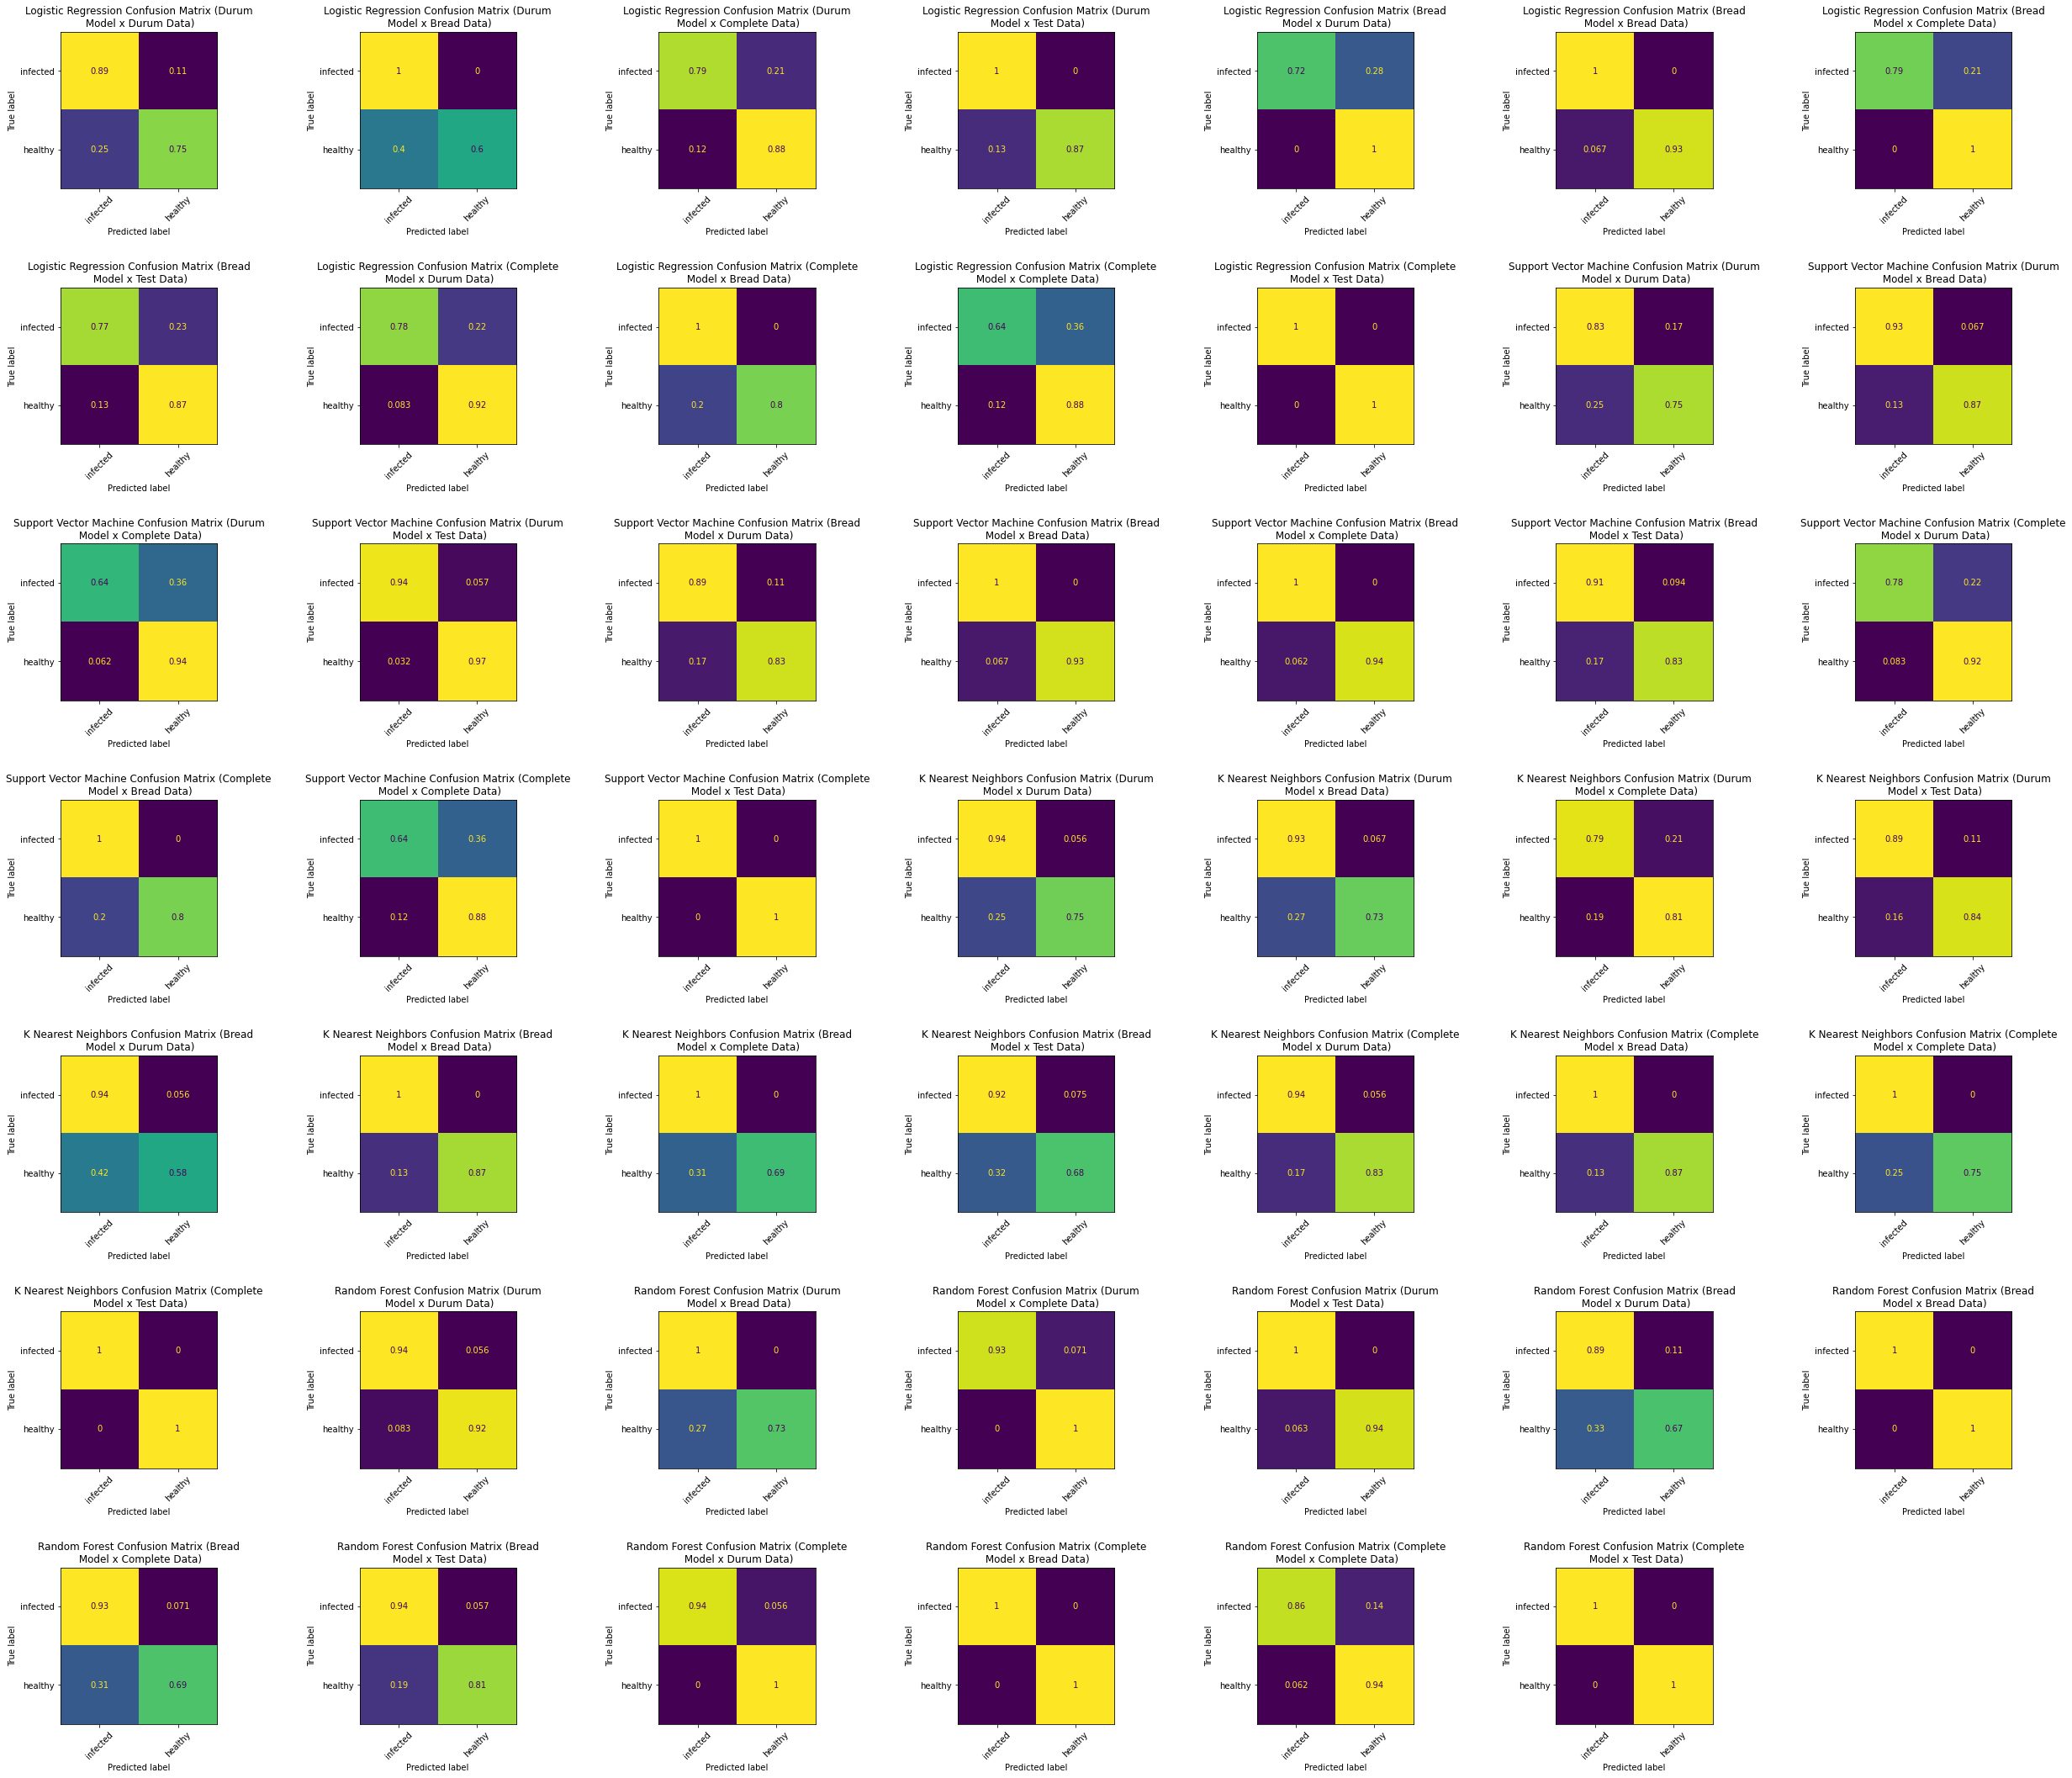

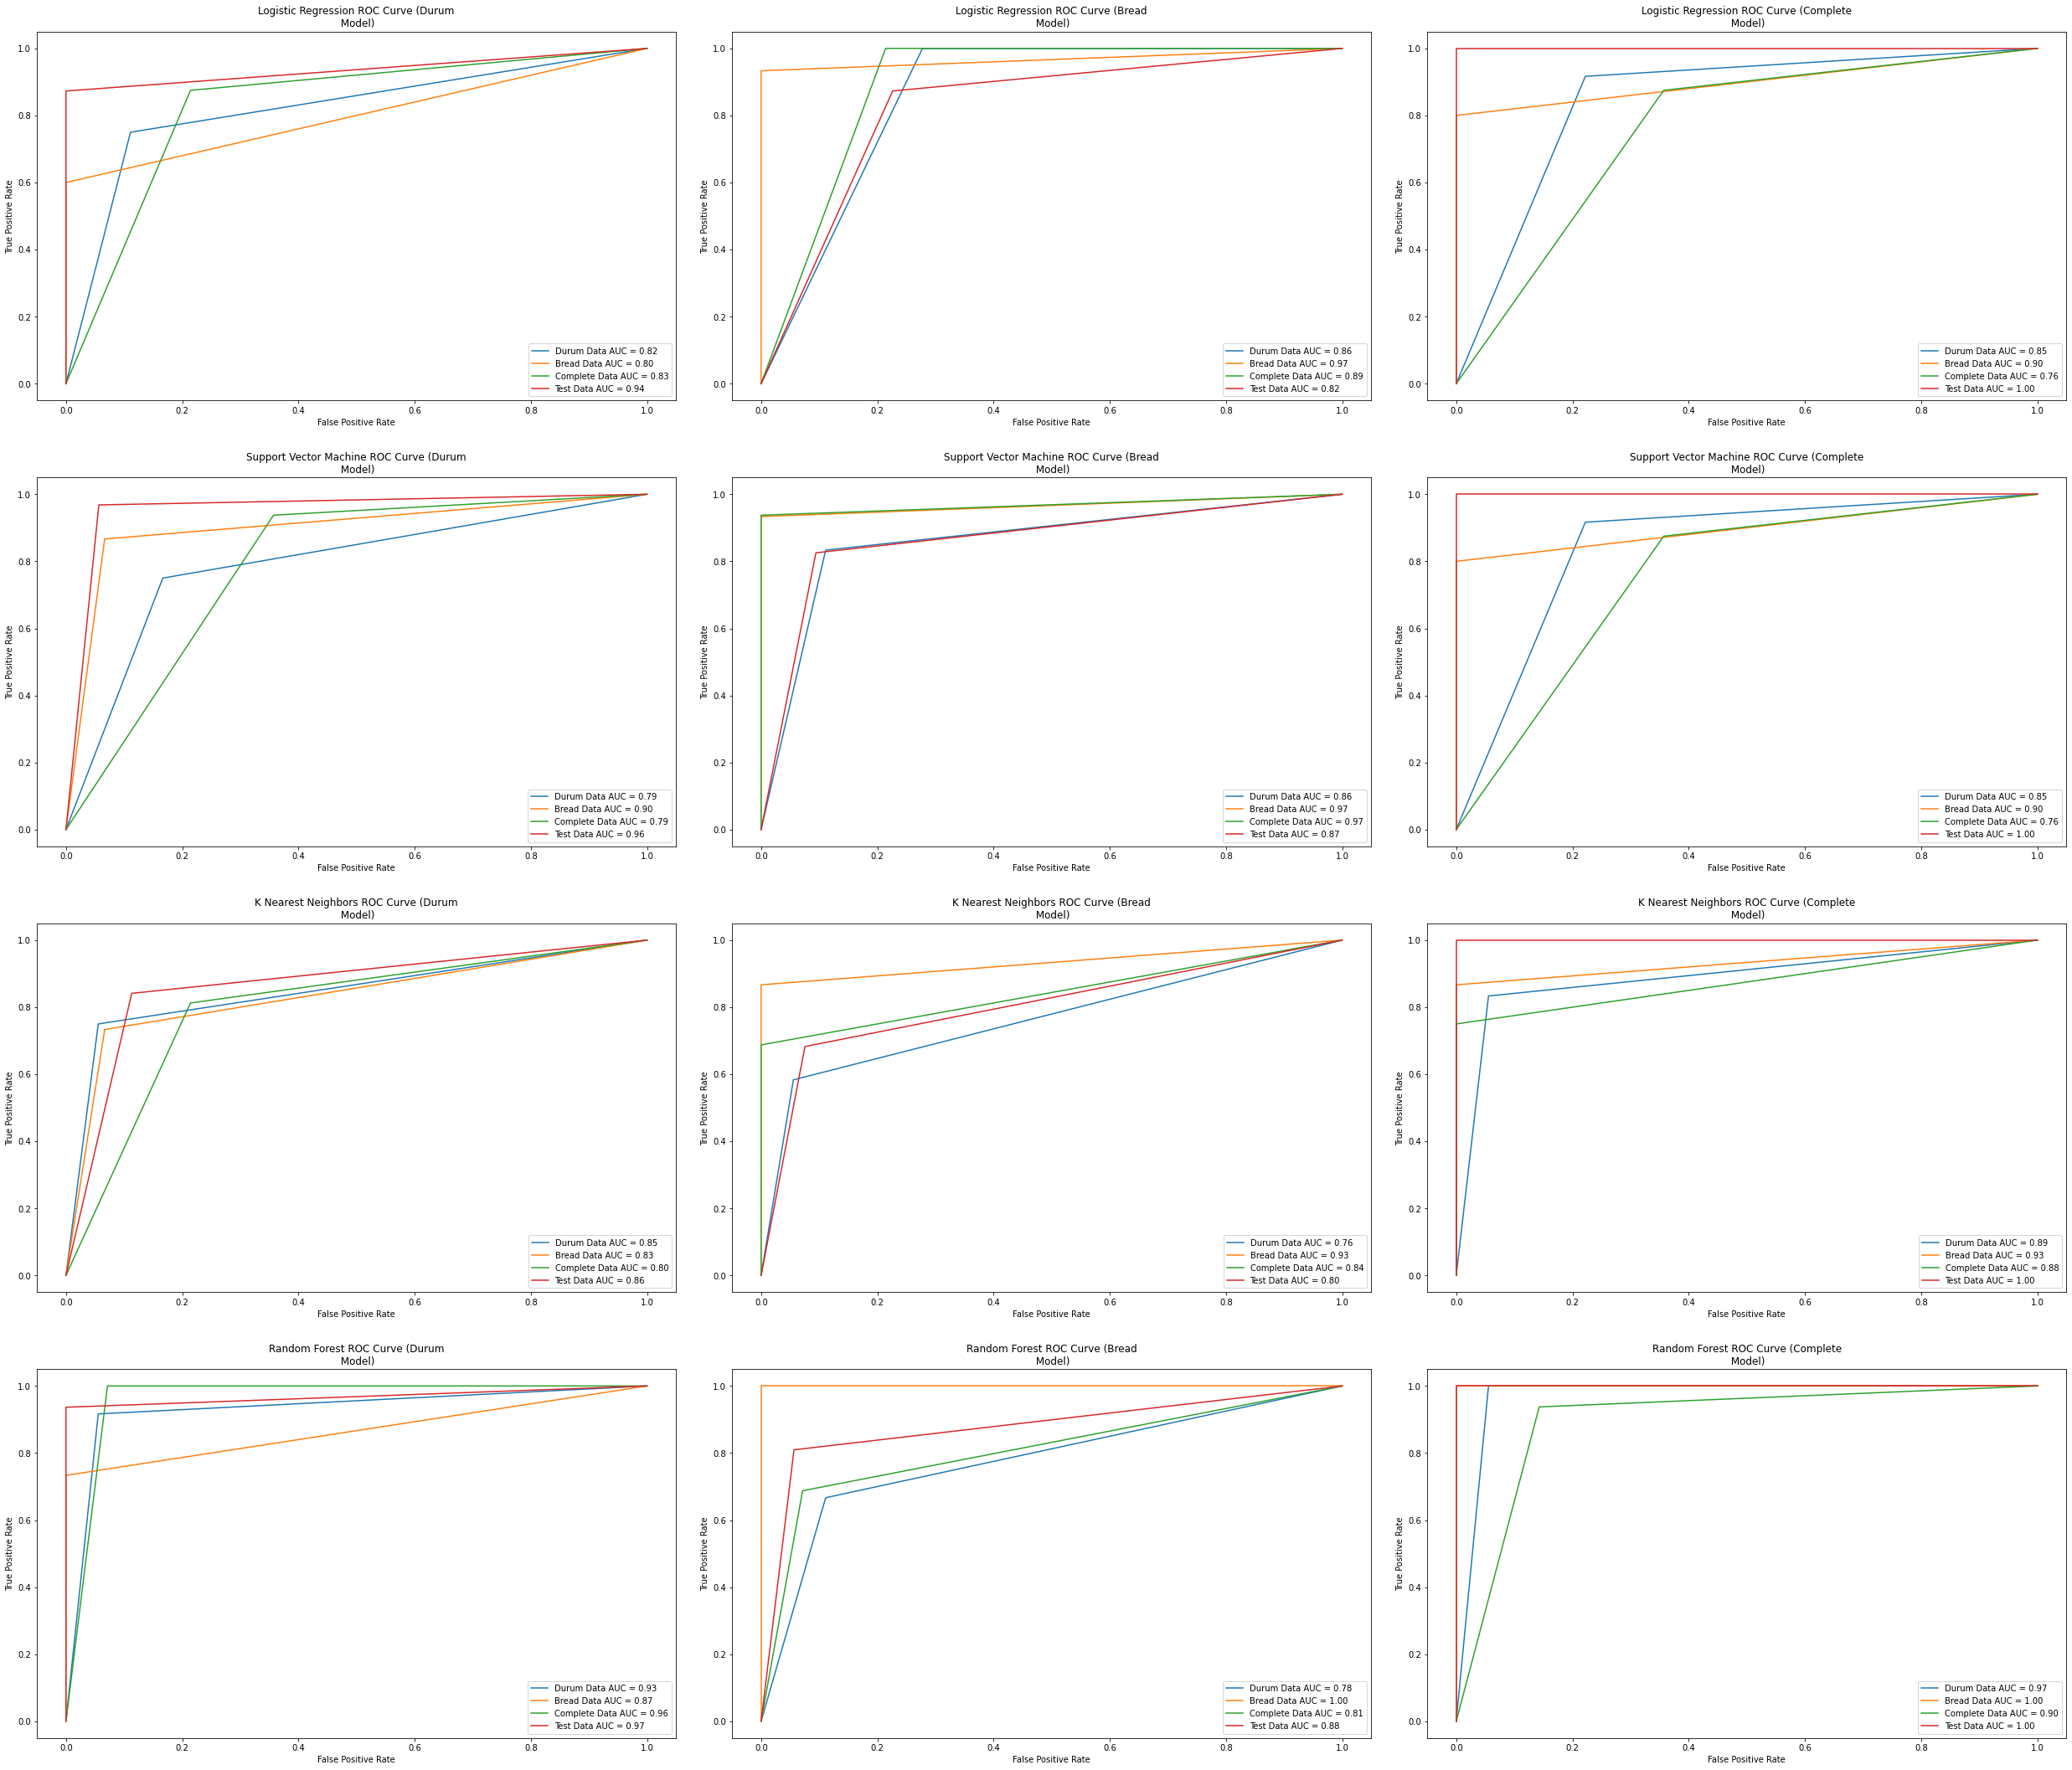

In [54]:
# Generation of confusion matrix for all models

Classification_Label = ['Logistic Regression', 'Support Vector Machine', 'K Nearest Neighbors', 'Random Forest']
Classification_Model = [ [LogR_model_Durum, LogR_model_Bread, LogR_model_Complete], [SVM_model_Durum, SVM_model_Bread, SVM_model_Complete], [KNN_model_Durum, KNN_model_Bread, KNN_model_Complete], [RanF_model_Durum, RanF_model_Bread, RanF_model_Complete]]
Train_Labels = ['Durum', 'Bread', 'Complete']
Test_Data_Sets = [(x_test_Durum, y_test_Durum), (x_test_Bread, y_test_Bread), (x_test_Complete, y_test_Complete), (x_test_Test, y_test_Test)]
Data_Set_Label = ['Durum', 'Bread', 'Complete', 'Test']


# Come common metrics used to gauge the models preformance
classification_model = []
train_data_used = []
test_data_used = []
false_positive_rate = [] # fp / (fp + tn)
false_negative_rate = [] # fn / (tp + fn)
true_negative_rate = [] # tn / (tn + fp)
negative_predictive_value = [] # tn / (tn + fn)
false_discovery_rate = [] # fp / (tp + fp)
true_positive_rate = [] # tp / (tp + fn)
precision = [] # tp / (tp + fp)
accuracy = [] # (tp + tn) / (tp + fp + fn + tn) 
f1_score = [] 
f2_score = []


# Setting up grid style plots for confusion matrix (conf) and ROC curves
fig_conf, axes_conf = plt.subplots(nrows=7, ncols=7, figsize=(35,30))
fig_roc, axes_roc = plt.subplots(nrows=4, ncols=3, figsize=(35,30))
axes_conf = axes_conf.flatten()
axes_roc = axes_roc.flatten()
i=0

for C_Label, C_Models in zip(Classification_Label, Classification_Model):
    for Model, T_Label in zip(C_Models, Train_Labels):
        for Test_Set, Test_Data_Label in zip(Test_Data_Sets, Data_Set_Label):
            
            y_test_pred = Model.predict(Test_Set[0])
            
            # For confusion matrix
            cf_matrix = confusion_matrix(Test_Set[1], y_test_pred, normalize='true')
            ncf_matrix = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]            
            disp_conf = ConfusionMatrixDisplay(ncf_matrix ,display_labels=['infected', 'healthy'])
            disp_conf.plot(ax=axes_conf[i], xticks_rotation=45)
            disp_conf.im_.colorbar.remove()
            axes_conf[i].title.set_text(f"{C_Label} Confusion Matrix ({T_Label}\n Model x {Test_Data_Label} Data)")

            # For metrics table
            tn, fp, fn, tp = cf_matrix.ravel()
            classification_model.append(C_Label)
            train_data_used.append(T_Label)
            test_data_used.append(Test_Data_Label)
            false_positive_rate.append(fp / (fp + tn))
            false_negative_rate.append(fn / (tp + fn)) 
            true_negative_rate.append(tn / (tn + fp)) 
            negative_predictive_value.append(tn / (tn + fn))
            false_discovery_rate.append(fp / (tp + fp))
            true_positive_rate.append(tp / (tp + fn))
            precision.append(tp / (tp + fp)) 
            accuracy.append((tp + tn) / (tp + fp + fn + tn))
            f1_score.append(fbeta_score(Test_Set[1], y_test_pred, beta=1))
            f2_score.append(fbeta_score(Test_Set[1], y_test_pred, beta=2))

            # For auc_roc curve
            fpr, tpr, thresholds = roc_curve(Test_Set[1], y_test_pred)
            roc_auc = auc(fpr, tpr)
            disp_roc = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)  
            disp_roc.plot(ax=axes_roc[i//4], label=f"{Test_Data_Label} Data AUC = {roc_auc:.2f}")
            axes_roc[i//4].title.set_text(f"{C_Label} ROC Curve ({T_Label}\n Model)")
             
            i = i + 1

axes_conf[48].set_axis_off()
fig_conf.tight_layout(pad=3.0)
fig_conf.savefig('confusion_matrix_04_10_2021_normalized.png')

fig_roc.tight_layout(pad=3.0)
fig_roc.savefig('ROC_curve_04_10_2021_normalized.png')

In [55]:
# Generate metrics table
metrics_df = pd.DataFrame(list(zip(classification_model,train_data_used,test_data_used,false_positive_rate,false_negative_rate,true_negative_rate,negative_predictive_value,false_discovery_rate,true_positive_rate,precision,accuracy,f1_score,f2_score)),
               columns =['Classifier', 'Training Data', 'Test Data', 'False Positive Rate', 'False Negative Rate', 'True Negative Rate', 'Negative Predictive Value', 'False Discovery Rate', 'True Positive Rate', 'Precision', 'Accuracy', 'F1 Score', 'F2 Score'])


metrics_df.to_csv('metrics_df_04_10_2021_normalized.csv',index=False)
